# Import Library

In [1]:
!pip install pandas PySastrawi matplotlib seaborn nltk tensorflow scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set gaya visualisasi
plt.style.use('ggplot')
sns.set_style('whitegrid')

# Library untuk preprocessing teks
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Library untuk vectorization
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from gensim.models import Word2Vec

# Library untuk pemodelan klasifikasi
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Library untuk evaluasi
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pd.set_option('max_colwidth', 180)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# EXPLORE DATA

In [3]:
# Baca dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dicoding/ulasan.csv')

data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,e6e83e76-4c4e-4a87-91c7-83a55f7b1454,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Sekarang tidak bisa komen di setiap komik deh,4,0,3.0.3,2025-02-24 12:34:04,NaN,NaN,3.0.3
1,96c0b35a-4356-4a20-9c74-e7a56c6e34cd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,mantap,5,0,NaN,2025-02-24 12:29:37,NaN,NaN,NaN
2,dc400802-14c8-4ddf-b7bf-18c752257d63,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,lumayan bagus aku juga pas baca lancar lancar aja.,5,0,3.5.4,2025-02-24 12:16:50,NaN,NaN,3.5.4
3,22715689-6e53-4340-8bbb-8c4c66daf0f3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Bagozz,tpi ngapa manhwa smut bisa lolos webtoon ya?",5,0,3.5.4,2025-02-24 12:15:18,NaN,NaN,3.5.4
4,c9e2e9ea-82a7-476e-8af3-6b9e4286d029,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Bagus sih... Tp banyak author yg hiatus trus gk balik' jd kek gimana ya,4,0,3.5.1,2025-02-24 11:59:49,NaN,NaN,3.5.1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              15000 non-null  object
 1   userName              15000 non-null  object
 2   userImage             15000 non-null  object
 3   content               15000 non-null  object
 4   score                 15000 non-null  int64 
 5   thumbsUpCount         15000 non-null  int64 
 6   reviewCreatedVersion  12505 non-null  object
 7   at                    15000 non-null  object
 8   replyContent          7 non-null      object
 9   repliedAt             7 non-null      object
 10  appVersion            12505 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [5]:
# Cek nilai yang hilang
print("\nJumlah nilai yang hilang per kolom:")
print(data.isnull().sum())


Jumlah nilai yang hilang per kolom:
reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion     2495
at                          0
replyContent            14993
repliedAt               14993
appVersion               2495
dtype: int64


In [6]:
# Cek distribusi rating
print("\nDistribusi rating:")
print(data['score'].value_counts())


Distribusi rating:
score
5    11011
4     1790
1     1072
3      743
2      384
Name: count, dtype: int64


In [7]:
# Inisialisasi stopwords bahasa Indonesia
nltk.download('stopwords')
try:
    stop_words = set(stopwords.words('indonesian'))
except:
    stop_words = set()  # Jika stopwords tidak tersedia, buat set kosong

# Inisialisasi stemmer dari Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk membersihkan teks
def clean_text(text):
    if isinstance(text, str):  # Pastikan input berupa string
        text = text.lower()  # Ubah ke huruf kecil
        text = re.sub(r'https?:\/\/\S+|www\.\S+', '', text)  # Hapus URL
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter non-alfabet
        text = re.sub(r'\b[a-zA-Z]\b', '', text)  # Hapus huruf tunggal
        words = text.split()
        words = [stemmer.stem(word) for word in words if word not in stop_words]  # Stemming & stopword removal
        return ' '.join(words)
    return ''

# Terapkan preprocessing
data['clean_text'] = data['content'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Pastikan ada data setelah preprocessing
print(data[['content', 'clean_text']].head())

                                                                   content  \
0                            Sekarang tidak bisa komen di setiap komik deh   
1                                                                   mantap   
2                       lumayan bagus aku juga pas baca lancar lancar aja.   
3                      Bagozz,tpi ngapa manhwa smut bisa lolos webtoon ya?   
4  Bagus sih... Tp banyak author yg hiatus trus gk balik' jd kek gimana ya   

                                               clean_text  
0                                         komen komik deh  
1                                                  mantap  
2                lumayan bagus pas baca lancar lancar aja  
3            bagozztpi ngapa manhwa smut lolos webtoon ya  
4  bagus sih tp author yg hiatus trus gk jd kek gimana ya  


In [9]:
# Fungsi konversi
def get_sentiment_from_score(score):
    if score in [1, 2]:
        return "negatif"
    elif score == 3:
        return "netral"
    elif score in [4, 5]:
        return "positif"
    return "netral"

# Terapkan konversi
data["sentiment"] = data["score"].apply(get_sentiment_from_score)

# Cek jumlah kategori
print(data["sentiment"].value_counts())

# Cek sampel data
print(data[["score", "sentiment"]].head(20))

sentiment
positif    12801
negatif     1456
netral       743
Name: count, dtype: int64
    score sentiment
0       4   positif
1       5   positif
2       5   positif
3       5   positif
4       4   positif
5       5   positif
6       5   positif
7       5   positif
8       5   positif
9       5   positif
10      5   positif
11      4   positif
12      5   positif
13      5   positif
14      5   positif
15      5   positif
16      1   negatif
17      5   positif
18      5   positif
19      5   positif


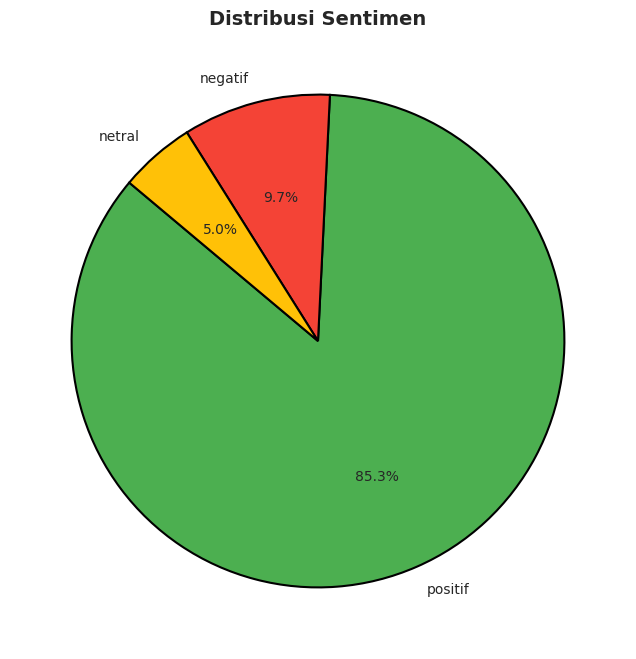

In [10]:
# Hitung jumlah masing-masing sentimen
sentiment_counts = data["sentiment"].value_counts()

# Warna khusus untuk tiap sentimen
colors = {'positif': '#4CAF50', 'netral': '#FFC107', 'negatif': '#F44336'}

# Buat pie chart dengan style seaborn
plt.figure(figsize=(8, 8))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=[colors[label] for label in sentiment_counts.index],
    startangle=140,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

# Tambahkan judul
plt.title("Distribusi Sentimen", fontsize=14, fontweight='bold')

# Tampilkan chart
plt.show()

In [11]:
dfx = pd.DataFrame(data.content.apply(clean_text))
dfx

,content
0,komen komik deh
1,mantap
2,lumayan bagus pas baca lancar lancar aja
3,bagozztpi ngapa manhwa smut lolos webtoon ya
4,bagus sih tp author yg hiatus trus gk jd kek gimana ya
...,...
14995,
14996,kerenn
14997,bayar saldo google play tolak
14998,muas


In [12]:
def Punctuation(string):

  # punctuation marks
  punctuations = '''!"#$%&'()*+,-./:;<=>?@[\]^f|]~'''

  # traverse the given string and if any punctuation
  # marks occur replace it with null
  for x in string.lower():
    if x in punctuations:
      string = string.replace(x, "")

  # Print string without punctuation
  return(string)
cleanPunc= lambda x: Punctuation(x)

In [13]:
dfx = pd.DataFrame(dfx.content.apply(cleanPunc))
dfx.head()

,content
0,komen komik deh
1,mantap
2,lumayan bagus pas baca lancar lancar aja
3,bagozztpi ngapa manhwa smut lolos webtoon ya
4,bagus sih tp author yg hiatus trus gk jd kek gimana ya


In [14]:
# STOPWORD REMOVAL

In [15]:
def get_stopword(stowordsfile):
  stopwords = []
  file_stopwords = open(stowordsfile, 'r')
  row = file_stopwords.readline()
  while row:
    word = row.strip()
    stopwords.append(row)
    row = file_stopwords.readline()
  file_stopwords.close()
  return stopwords

In [16]:
stop_words_indo = get_stopword('/content/drive/MyDrive/Colab Notebooks/dicoding/stopwordsindo.txt')

In [17]:
def stopwords(text):

  tokens = word_tokenize(text)
  filtered = []

  for w in tokens:
    if w not in stop_words_indo:
      filtered.append(w)

  hasil = ' '.join(filtered)
  return hasil

st = lambda x: stopwords(x)

In [18]:
dfx = pd.DataFrame(dfx.content.apply(st))
dfx.head()

,content
0,komen komik deh
1,mantap
2,lumayan bagus pas baca lancar lancar aja
3,bagozztpi ngapa manhwa smut lolos webtoon ya
4,bagus sih tp author yg hiatus trus gk jd kek gimana ya


# PEMBUATAN MODEL KLASIFIKASI

In [19]:
from sklearn.preprocessing import LabelEncoder

# Encode label
y = LabelEncoder().fit_transform(data['sentiment'])
X = dfx['content']

# MODEL 1: LSTM + TF-IDF (80/20)

In [20]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X).toarray()

# Split Data untuk TF-IDF
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# LSTM Model (TF-IDF)
model1 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.fit(X_train_tfidf, y_train_tfidf, epochs=5, batch_size=32, validation_data=(X_test_tfidf, y_test_tfidf))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.8341 - loss: 0.5802 - val_accuracy: 0.8847 - val_loss: 0.3389
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8903 - loss: 0.3208 - val_accuracy: 0.8900 - val_loss: 0.3313
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9098 - loss: 0.2642 - val_accuracy: 0.8907 - val_loss: 0.3386
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9225 - loss: 0.2430 - val_accuracy: 0.8807 - val_loss: 0.3644
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9399 - loss: 0.1938 - val_accuracy: 0.8793 - val_loss: 0.3929


# SKEMA 2: CNN + Word2Vec (80/20)

In [21]:
# Word2Vec Training
tokenized_texts = [text.split() for text in X]
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=128, window=5, min_count=1, workers=4)
word_vectors = w2v_model.wv

# Tokenizer untuk Word2Vec
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
max_len = 100  # Batas panjang teks
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

# Split Data untuk Word2Vec
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_pad, y, test_size=0.2, random_state=42
)

# Embedding Matrix
word_index = tokenizer.word_index
embedding_dim = 128
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

# CNN Model (Word2Vec)
model2 = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train_w2v, y_train_w2v, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.8421 - loss: 0.5419 - val_accuracy: 0.8433 - val_loss: 0.4361
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8569 - loss: 0.4011 - val_accuracy: 0.8487 - val_loss: 0.4268
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8604 - loss: 0.3796 - val_accuracy: 0.8529 - val_loss: 0.4222
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8608 - loss: 0.3935 - val_accuracy: 0.8575 - val_loss: 0.4302
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.8615 - loss: 0.3929 - val_accuracy: 0.8500 - val_loss: 0.4460


# SKEMA 3: LSTM + Word2Vec (70/30)

In [22]:
# Split Data untuk Word2Vec (70:30)
X_train_w2v3, X_test_w2v3, y_train_w2v3, y_test_w2v3 = train_test_split(
    X_pad, y, test_size=0.3, random_state=42
)

# Model LSTM dengan Word2Vec
model3 = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(128),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.fit(X_train_w2v3, y_train_w2v3, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 59s 214ms/step - accuracy: 0.8325 - loss: 0.6600 - val_accuracy: 0.8443 - val_loss: 0.5480
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 68s 161ms/step - accuracy: 0.8550 - loss: 0.5367 - val_accuracy: 0.8443 - val_loss: 0.5316
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 80s 154ms/step - accuracy: 0.8558 - loss: 0.5304 - val_accuracy: 0.8443 - val_loss: 0.5328
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.8547 - loss: 0.5233 - val_accuracy: 0.8443 - val_loss: 0.5325
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 40s 151ms/step - accuracy: 0.8507 - loss: 0.5360 - val_accuracy: 0.8443 - val_loss: 0.5331


# HASIL

In [23]:
# Evaluasi Model
accuracy1 = model1.evaluate(X_test_tfidf, y_test_tfidf)[1]  # LSTM + TF-IDF
accuracy2 = model2.evaluate(X_test_w2v, y_test_w2v)[1]  # CNN + Word2Vec
accuracy3 = model3.evaluate(X_test_w2v3, y_test_w2v3)[1]  # LSTM + Word2Vec (70:30)

print("LSTM + TF-IDF (80:20) Accuracy:", accuracy1)
print("CNN + Word2Vec (80:20) Accuracy:", accuracy2)
print("LSTM + Word2Vec (70:30) Accuracy:", accuracy3)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8716 - loss: 0.3891
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8611 - loss: 0.4219
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.8543 - loss: 0.5109
LSTM + TF-IDF (80:20) Accuracy: 0.8793333172798157
CNN + Word2Vec (80:20) Accuracy: 0.8659999966621399
LSTM + Word2Vec (70:30) Accuracy: 0.8588888645172119


# INFERENCE

In [24]:
def predict_sentiment(text):
    """Fungsi untuk melakukan prediksi sentimen dari teks input menggunakan LSTM + TF-IDF"""
    text_tfidf = tfidf.transform([text]).toarray()  # Transform ke TF-IDF

    # Pastikan dimensi sesuai dengan model
    if text_tfidf.shape[1] < X_train_tfidf.shape[1]:
        text_tfidf = np.pad(text_tfidf, ((0, 0), (0, X_train_tfidf.shape[1] - text_tfidf.shape[1])), mode='constant')
    elif text_tfidf.shape[1] > X_train_tfidf.shape[1]:
        text_tfidf = text_tfidf[:, :X_train_tfidf.shape[1]]

    prediction = model1.predict(text_tfidf)
    sentiment_labels = ['Negatif', 'Netral', 'Positif']
    return sentiment_labels[np.argmax(prediction)]

# Contoh penggunaan
new_text = "Aplikasi ini sangat bagus!"
print("Prediksi Sentimen:", predict_sentiment(new_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Prediksi Sentimen: Positif
